### Suffix tree construction

To be able to optimize the search for patterns within strings we need to do a couple of steps.
Firstly we need to construct a suffix tree that we can search through.
For this construction the most naive version would take O(n^2) time to construct and O(n^2) space
However it is possible to optimize it to O(n) runtime and O(n) space
Space can be optimized by change the edges from symbols to idx
runtime can be optimized by...

#### Naive construction

In [1]:
def construct_suffix_tree(s):
    # First we add $ to the string
    s = s + '$'
    suffix_tree = {}
    
    # make list of all suffixes
    suffixes = [s[i:] for i in range(len(s))]
    
    # insert suffixes
    for suffix in suffixes:
        starting_char = suffix[0]
        if starting_char not in suffix_tree:
            suffix_tree[starting_char] = []
        
        # Append the suffix to the list for the starting character
        suffix_tree[starting_char].append(suffix)
    
    # Return the suffix tree dictionary
    return suffix_tree

# Run the algoo
s = "banana"
suffix_tree = construct_suffix_tree(s)
print(suffix_tree)

{'b': ['banana$'], 'a': ['anana$', 'ana$', 'a$'], 'n': ['nana$', 'na$'], '$': ['$']}


Above might not give a usefull output. below is an outline of the algorithm 

In [2]:
# Start at the root of Ni


# Find the longest path from the root which matches a prefix of S[i+1..m]$


# Match ends either at the node (say w) or in the middle of an edge [say (u, v)].


# If it is in the middle of an edge (u, v), break the edge (u, v) into two edges 
# by inserting a new node w just after the last character on the edge that matched a 
# character in S[i+l..m] and just before the first character on the edge that mismatched. 
# The new edge (u, w) is labelled with the part of the (u, v) label that matched with S[i+1..m], 
# and the new edge (w, v) is labelled with the remaining part of the (u, v) label.


# Create a new edge (w, i+1) from w to a new leaf labelled i+1 and it labels the new edge with 
# the unmatched part of suffix S[i+1..m]

##### Class based construction of a trie
Below a class was constructed to represent the nodes that points towards their children nodes. This can be used to form a tree of the letters found in each suffix.

In [3]:
from graphviz import Digraph

class SuffixTreeNode:
    def __init__(self):
        self.children = {}          # Dictionary to hold children nodes (edge label -> child node)
        self.index = -1             # Position in string
        self.suffix_number = None     # placeholder for final index of a suffix


class SuffixTree:

    ####################################
    ########## Construction ############
    def __init__(self, text):
        self.text = text + "$"              # add $
        self.root = SuffixTreeNode()        
        self.build_suffix_tree()            # use function to build suffixtree

    def build_suffix_tree(self):
        """
        build the suffix tree inserting all suffixes of the string we give
        """
        n = len(self.text)
        
        for i in range(n):
            current_node = self.root
            suffix = self.text[i:]  # slice the string to make suffixes (i starts with 0 so all of the string first)
            for idx in range(len(suffix)):
                if suffix[idx] not in current_node.children: # character not found, create a new node
                    current_node.children[suffix[idx]] = SuffixTreeNode()
                current_node = current_node.children[suffix[idx]]  # Move to the child node we just made
                current_node.index = i      
            current_node.suffix_number = i  # updates the index when suffix is placed

    ###############################
    ####### Visualization #########
    def visualize(self, filename="suffix_tree"):
        """
        Visualize the suffix tree using Graphviz.
        """
        # create Graphviz object 
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                      edge_attr={'fontsize': '10', 'fontcolor': 'blue', 'labelfontsize': '10', 
                                 'labeldistance': '1', 'labelangle': '0'})
        self.visualize_helper(self.root, dot)
        dot.render(filename, format='png', cleanup=True)    # saves an image of the tree in root folder
        print(f"Visualization saved as {filename}.png")
        return dot

    def visualize_helper(self, node, dot, parent_id="root", edge_label=""):
        """
        Helper function - add nodes and edges to the Graphviz object.
        """
        node_id = str(id(node))
        
        # Node label - if suffix_number defined we create a label indicating the order the suffixes where added. only nodes with $ get a label
        if node.suffix_number != None:
            label = f"({node.suffix_number})"
        else:
            label = ""

        # adjust node size in Digraph object
        dot.node(node_id, label, width="0.5", height="0.5", style="filled", color="lightgrey")

        # add edge from parent to current node
        if parent_id != "root":
            dot.edge(parent_id, node_id, label=edge_label, fontsize="25", fontcolor="red")  # add and adjust edge text fpr digraph

        # Recursively add children
        for char, child_node in node.children.items():
            self.visualize_helper(child_node, dot, node_id, edge_label=char)


    ########################################
    ######## Additional functions ##########    
    def find_longest_branch(self):
        """
        Find the longest branch in the suffix tree
        Returns both the longest str and the length
        """
        # using depth first search
        def dfs(node, current_path):
            nonlocal max_length, longest_string 
            if node.index != -1:                    # if leaf, then chek if current path is longest we have looked at yet
                if len(current_path) > max_length: 
                    max_length = len(current_path)
                    longest_string = current_path
            
            # traverse all children recursively
            for char, child_node in node.children.items():
                dfs(child_node, current_path + char)

        # Initialize variables
        max_length = 0
        longest_string = ""
        # Start DFS from the root
        dfs(self.root, "")

        return max_length, longest_string


    def get_all_suffixes(self):
        """
        Collect all suffixes stored in the suffix tree by DFS
        Returns a list of all the suffixs in the tree
        """
        suffixes = []

        def dfs(node, current_suffix):
            # if leaf -> add suffix to list
            if node.suffix_number != None:
                suffixes.append(current_suffix)
            
            # Recursively traverse all children
            for char, child_node in node.children.items():
                dfs(child_node, current_suffix + char)

        # Start DFS from the root
        dfs(self.root, "")
        
        return suffixes



In [4]:
# usage
string = "banana"
suffix_tree = SuffixTree(string)

#### Validating the suffix trees

When the tree construction is complete, its a very good idea to validate if the trees are actually suffix trees. To do this we can check the different criteria that such a tree has and check if our trees generated follow those criteria.

Criteria we could potentially check:
- Spelling of the substring is correct, so we check if the longest string is the same length and is spell the same way as the original string
- Every node only has outgoing edges with unique starting symbols
- Check that every suffix possible is accounted for. There should be the same number of 
'$' as there are suffixes 

Below are some typical test sequences used as examples

##### Confirming criterias

Lets try to confirm some of the criteria outlined above. Lets start by investigating the longest branch in the tree

In [5]:
# defining a test string we wanna use and making the tree
string = "banana"
string_s = string + "$"         # add $ to string
suffix_tree = SuffixTree(string)

print("suffix_tree was generated with the string:", string)


#### Find longest branch in suffix tree #####
length, longest_branch = suffix_tree.find_longest_branch()
input_length = len(string_s)

print("\n### The length check ###")
print("Longest branch is:", length, "length and it is:", longest_branch)
print("Input string is:", input_length, "length and it is:", string_s)

#### Spell checking ####
print("\n### The spell check ###")
print("spelled correctly?", longest_branch == string_s)

#### Double check every suffix is in tree ####
actual_suffixes = sorted(suffix_tree.get_all_suffixes())
expected_suffixes = sorted([string_s[i:] for i in range(len(string_s))])
print("\n### Check all suffixes are present ###")
print("Suffixes found in tree:", actual_suffixes)
print("Expected suffixes:", expected_suffixes)
print("same?", actual_suffixes == expected_suffixes)

suffix_tree was generated with the string: banana

### The length check ###
Longest branch is: 7 length and it is: banana$
Input string is: 7 length and it is: banana$

### The spell check ###
spelled correctly? True

### Check all suffixes are present ###
Suffixes found in tree: ['$', 'a$', 'ana$', 'anana$', 'banana$', 'na$', 'nana$']
Expected suffixes: ['$', 'a$', 'ana$', 'anana$', 'banana$', 'na$', 'nana$']
same? True


##### Visualize the tree

Firstly using the function visualize and visualize helper. we can generate an image of the trees we make with graphviz.

Visualization saved as suffix_tree.png


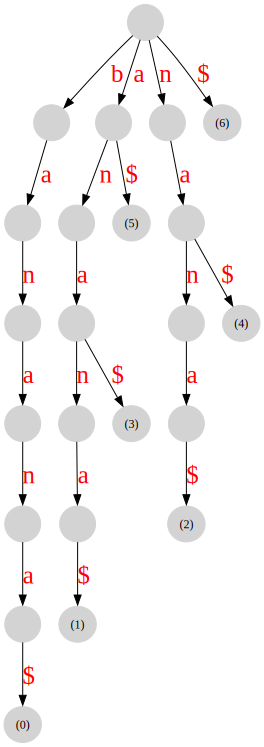

In [6]:
string = "banana"
suffix_tree = SuffixTree(string)

# Visualize the tree using Graphviz
graph = suffix_tree.visualize()
display(graph)

#### Compressed Trie - suffix tree
This solution does give us a suffix tree that we could search through. But it takes O(n^2) time and space. This can be speed up to a potential O(n+m) if we instead compress the the tree.
Instead of having a single charater on each edge, we can have indices representing slices of the original string. this enables us to not have as many nodes to construct and eventually check. 


Current ideas:
- we craft the original tree and then look through it and compress all the segments where there are only 1 child (Not good for construction time)
- all edges start out as their full suffix indicated by their index. When new suffixes add more than what would have been 1 child node we split the original index. 
- We dont add one suffix at a time, but instead add every suffix incrementally 


book uses:
- range defined by start and end of the slice
- a parent list
- a child list
- a sibling list
- a suffix link

helper function edge_length:
gets the edge_length start -> end (range)

suffix_tree functin
string
length
root


new_node function


In [7]:
# book outline
# idea is to add entire suffixes at a time, if no outgoing node matches the current
# suffix then we add it as a single node where the edge is the indices representng 
# suffix. If we find an edge our current suffix matches with we more along the edge
# and check if the characters are the same, if not we create a split.
# After a split we can add the rest of the current suffix as its own node
# and we need to update the indices on the edge we just followed, aswell as the later
# part of that edge.

# see page 99 in mailund book. We need to ensure that our nodes/edges holds
# the information about their from -> to so that when we update them we can 
# edit these, this information is what our edges should hold.

# (book uses a list for parents, siblings and children. My implemenation only uses a dict for children)



class Node(object):
    def __init__(self, start=None, end=None, suffix_number=None, parent=None):
        self.start = start                      # start idx for string
        self.end = end                          # end idx for string 
        self.suffix_number = suffix_number      # order the $ are add to tree
        self.children = {}                      # children as dictionary, key = a unique charater, value = Npde(object)
        self.parent = parent                    # Defining a parent node allows us to go back up in the tree
        #self.suffixlink =   # <---- for mccreicht  
    
class SuffixTree:
    def __init__(self, string):
        self.string = string + "$"
        self.root = Node()
        self.build_tree(string)
    
    
    def build_tree(self, string):
        string = string + "$"
        n = len(string)
        
        for i in range(n):
            current_node = self.root
            suffix = string[i:]
            self.insert_suffix(current_node, suffix, i, i)
    
    def insert_suffix(self, current_node, suffix, suffix_start, suffix_index):
        first_char = suffix[0]

        ### outgoing edge - check if suffix has an edge it can follow
        #case 1: No children matching suffix - so we add one
        if first_char not in current_node.children:
            current_node.children[first_char] = Node(suffix_start, len(self.string), suffix_index, current_node)       
        
        #case2: We have an outgoing edge!
        elif first_char in current_node.children:
            edge_node = current_node.children[first_char] # move down to the node we found
            common_len = self.find_common_prefix_length(suffix, edge_node)
            #case2.1: if we moved all the way out of the edge
            if common_len == edge_node.end - edge_node.start:
                self.insert_suffix(edge_node, suffix[common_len:], suffix_start+common_len, suffix_index)
            #case2.2: split in edge found, insert internal node 
            else:
                self.split_edge(current_node, edge_node, common_len, suffix, suffix_start, suffix_index)


    def find_common_prefix_length(self, suffix, edge):
        """
        Find the length of a common prefix between two strings
        """
        common_len = 0
        edge_start = edge.start
        edge_end = edge.end
        
        # while we dont exceed the suffix length
        while common_len < len(suffix) and edge_start + common_len < edge_end:
            if suffix[common_len] == self.string[edge_start + common_len]:        # if the letters in suffix and string is the same -> contentiue
                common_len += 1
            else:
                break   # end when no longer the same, this is our breaking index where we split
        return common_len

    def split_edge(self, parent_node, edge, common_length, suffix, suffix_start, suffix_index):
        """
        we found a missmatch and insert a new node inbetween existing childnode and parent
        This new internal node becomes new child of the current parent node and parent to current child node
        Then we add the remainder of the current suffix as a new child node (now sibling to old childnode)
        """
        #create the new internal node - will be the parent of the split edge and the new leaf
        internal_node = Node(start=edge.start, end=edge.start + common_length, parent=parent_node) # it idx ends at the common lenght from where it starts
        parent_node.children[self.string[edge.start]] = internal_node

        # update the existing edge's start
        edge.start += common_length # leaf node now starts at the new split
        edge.parent = internal_node
        internal_node.children[self.string[edge.start]] = edge
        
        # create new leaf node with rest of current suffix
        remaining_suffix_start = suffix_start + common_length
        internal_node.children[suffix[common_length]] = Node(start=remaining_suffix_start, end=len(self.string), suffix_number=suffix_index, parent=internal_node)

####################################
### Visualization using graphviz ###
    def visualize(self, filename="Suffix_tree_compressed"):
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                      edge_attr={'fontsize': '15', 'fontcolor': 'red', 'labelfontsize': '10', 
                                 'labeldistance': '1', 'labelangle': '0'})
        self.add_edges(dot, self.root, node_id="root")
        dot.render(filename, format='png', cleanup=True)    # saves an image of the tree in root folder
        print(f"Visualization saved as {filename}.png")
        return dot

    def add_edges(self, dot, node, node_id):
        #add each child and its corresponding edge label
        for i, (char, child) in enumerate(node.children.items()):
            child_id = f"{node_id}_{i}"  # unique id for each child node

            # check if df_numbering has been added
            if hasattr(child, 'df_number'):
            # check if the child is a leaf
                if not child.children:  #Leaf node (no children)
                    leaf_label = f"S:{child.suffix_number}, df:{child.df_number}"
                    dot.node(child_id, leaf_label, style="filled", color="lightgrey")
                else:
                    dot.node(child_id, "", style="filled", color="lightgrey")  # Internal nodes remain unlabeled
            else:
                if not child.children:  #Leaf node (no children)
                    leaf_label = f"S:{child.suffix_number}"
                    dot.node(child_id, leaf_label, style="filled", color="lightgrey")
                else:
                    dot.node(child_id, "", style="filled", color="lightgrey")  # Internal nodes remain unlabeled
            
            #edge label
            #label = self.string[child.start:child.end]     # write the string labels
            #label = f"({child.start}, {child.end})"         # write the idx on labels
            label = self.string[child.start:child.end] + f" ({child.start}, {child.end})" 
            dot.edge(node_id, child_id, label=label)

            # Recursively add edges for the child
            self.add_edges(dot, child, child_id)  
   
############################
### validation functions ###

    def find_longest_branch(self):
        """
        using dfs to find longest branch in the suffix tree
        Returns both the longest str and the corosponding length
        """
        def dfs(node, current_path):
            if not node.children:
                return current_path
            
            longest_branch = current_path
            for child in node.children.values():
                edge_label = self.string[child.start:child.end]
                branch = dfs(child, current_path + edge_label) # recursively move out a branch
                if len(branch) > len(longest_branch): # check if lonest we've seen
                    longest_branch = branch
            return longest_branch
        
        # recursion start
        return dfs(self.root, "")

    def get_all_suffixes(self):
        """
        using dfs we look through the tree to find all the suffixes
        returns a list of all suffixes found throughout the constructed tree
        """
        suffixes = []
        def dfs(node, current_path):
            if not node.children:
                return suffixes.append(current_path) # leaf node, so we add suffix

            for child in node.children.values(): # look at
                edge_label = self.string[child.start:child.end]
                dfs(child, current_path + edge_label) # recussively search tree

        dfs(self.root, "") # initiate search
        return suffixes
   
    def count_outgoing_edges(self):
        """
        Count the number of outgoing edges for internal nodes. internal nodes can minimum have 2 
        children, and at max have the same as number of unique symbols in the stirng.
        """
        # define criteria
        min_children = 2
        max_children = len(set(self.string))    # length of unique char in the string        
        failed_nodes = []                       # keep track of failed nodes

        # depth first search
        def dfs(node):
            if not node.children: # no children, so its a leaf
                return 

            for child in node.children.values():
                dfs(child) # recursively move out branch

            # check if number of children is correct
            num_children = len(node.children)
            if num_children < min_children or num_children > max_children:
                failed_nodes.append(node)


            return
        
        dfs(self.root)
        return failed_nodes

    def check_unique_children(self):
        """
        check that each internal node has unique values in the dictionary for children
        Returns a list of failed nodes, if empty all passed.
        """
        failed_nodes = []

        def dfs(node):
            if not node.children: # no children, so its a leaf
                return 
            
            for child in node.children.values():
                dfs(child) # recursively move out branch

            # check if all children are unique
            all_children = list(node.children.values())
            unique_children = set(all_children)
            unique_check = len(all_children) == len(unique_children)
            if unique_check == False:
                failed_nodes.append(node)

        dfs(self.root)
        return failed_nodes
    
    def node_visits(self):
        """
        Find number of times we visist a given node with a depth-first approach. 
        We should only visit each node once.
        Returns...
        """
        visit_counts = {}
        failed_nodes = []

        def dfs(node):
            #recursively visit all children
            for child in node.children.values():
                dfs(child)

            if node in visit_counts:
                visit_counts[node] += 1
            else:
                visit_counts[node] = 1

            if visit_counts[node] > 1:
                failed_nodes.append(node)            
            
        dfs(self.root) # initialize recursion
        return failed_nodes
    

#################################
### helper functions ###
    def df_numbering(self):
        '''
        Does a depth-first search through the tree and adds the ordering to the leaves
        df_number is added to the node objects and two lists of corosponding suffix- and df-numbering
        is returned. Additionally also adds a leaflist of the depth-first numbers to each internal node.
        '''
        count = [0] #mutable counter
        df_list = []
        suffix_list = []

        def dfs(node):
            if not node.children: #base case: no children, so its a leaf
                node.df_number = count[0]
                node.leaf_range = (count[0], count[0]) # [count[0]]
                count[0] += 1
                df_list.append(node.df_number)
                suffix_list.append(node.suffix_number)
                return node.leaf_range

            # visit all children
            min_df = float("inf") #leaf_list = []
            max_df = -float("inf") 

            for child in node.children.values():
                # leaf_list.extend(dfs(child)) # recursively move out branch
                child_leaf_range = dfs(child)
                min_df = min(min_df, child_leaf_range[0])
                max_df = max(min_df, child_leaf_range[1])

            node.leaf_range = (min_df, max_df) # node.leaf_list = leaf_list

            return node.leaf_range # leaf_list
        
        dfs(self.root)
        return suffix_list, df_list


# test_string = "mississippi"

# suffix_tree = SuffixTree(test_string)
# s_list, df_list = suffix_tree.df_numbering()

# # print(s_list, f"\n{df_list}")
# # print(suffix_tree.root.children['i'].leaf_range)
# suffix_tree.visualize()

##### Validating the suffix tree
We can validate the suffix tree with some of the same criteria as the trie we did earlier.
we can use the the length check, spell check and the number of suffixes.
Something to keep in mind is that we can no longer just look at the keys in the dictionary of the nodes to determine their corosponding string, instead we look at the index intervals and use those to slice the string.

In [8]:
def validate_suffix_tree(input_string, verbose = True):
    """
    collective function to use all the validation functions at the same time
    Returns a list where the indices corospond to the follow:
    ["input_string", "length_check", "spell_check", "all_same_suffix_check"]
    Verbose indicates if an output should be printed or if only the list should be returned
    """
    
    string_s = input_string + "$"
    suffix_tree = SuffixTree(input_string)

    #### Find longest branch in suffix tree ##### + spellcheck
    longest_branch = suffix_tree.find_longest_branch()
    output_length= len(longest_branch)
    input_length = len(string_s)

    #### Double check every suffix is in tree ####
    actual_suffixes = sorted(suffix_tree.get_all_suffixes())
    expected_suffixes = sorted([string_s[i:] for i in range(len(string_s))])

    #### count edges ####
    failed_count_edges = suffix_tree.count_outgoing_edges()
    count_check = False
    if failed_count_edges == []:
        count_check = True

    #### unique children ####
    failed_unique_children = suffix_tree.check_unique_children()
    unique_child_check = False
    if failed_unique_children == []:
        unique_child_check = True

    #### Node visits during depth-first search ####
    too_many_visits = suffix_tree.node_visits()
    visits_check = False
    if too_many_visits == []:
        visits_check = True

    if verbose == True:
        print("suffix_tree was generated with the string:", input_string)
        print("same length? -", output_length == input_length)
        #### Spell checking ####
        print("spelled correctly? -", longest_branch == string_s)
        print("obs suffixes:", actual_suffixes)
        print("exp suffixes:", expected_suffixes)
        print("All suffixes same? -", actual_suffixes == expected_suffixes)
        print("All internal nodes have correct number of children?", count_check)
        print("All internal nodes have unique children?", unique_child_check)
        print("All nodes were only visited once?", visits_check)


    return [input_string, 
            output_length==input_length, 
            longest_branch == string_s, 
            actual_suffixes == expected_suffixes,
            count_check,
            unique_child_check,
            visits_check]


string = "mississippi"
validate_suffix_tree(string, verbose=False)

['mississippi', True, True, True, True, True, True]

Visualization saved as Suffix_tree_compressed.png


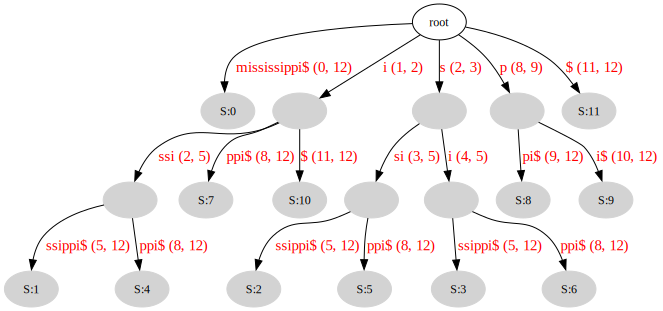

In [9]:
suffix_tree = SuffixTree(string)
suffix_tree.visualize()

##### Random input string testing
Let try to create a random set of strings to see if it is working in every scenario and not just the test cases i have used up until not.

In [10]:
import random 

def random_input_string(n, symbols):
    """
    creates a string of the specified length n with randomly selected symbols from the allowed
    ones indicated by symbols.
    """
    return ''.join(random.choice(symbols) for i in range(n))

n = 10
symbols = 'agct'
string = random_input_string(n, symbols)

validate_suffix_tree(string)

suffix_tree was generated with the string: cgactcagtg
same length? - True
spelled correctly? - True
obs suffixes: ['$', 'actcagtg$', 'agtg$', 'cagtg$', 'cgactcagtg$', 'ctcagtg$', 'g$', 'gactcagtg$', 'gtg$', 'tcagtg$', 'tg$']
exp suffixes: ['$', 'actcagtg$', 'agtg$', 'cagtg$', 'cgactcagtg$', 'ctcagtg$', 'g$', 'gactcagtg$', 'gtg$', 'tcagtg$', 'tg$']
All suffixes same? - True
All internal nodes have correct number of children? True
All internal nodes have unique children? True
All nodes were only visited once? True


['cgactcagtg', True, True, True, True, True, True]

And instead of just running the above code manually we just iterativly check that all random cases are running as they should

In [11]:
test_duration = 10000
n = 10
symbols = 'agct'

for i in range(test_duration):
    string = random_input_string(n, symbols)
    
    checks = validate_suffix_tree(string, verbose=False)
    len_check = checks[1]
    spell_check = checks[2]
    suffix_check = checks[3]
    count_check = checks[4]
    child_check = checks[5]
    visits_check = checks[6]

    # if any check fails break loop and report
    if len_check == False or spell_check == False or suffix_check == False or count_check == False or child_check == False or visits_check == False:
        print("Test failed with:", string)
        print("length:", len_check)
        print("spelling:", spell_check)
        print("suffix_check:", suffix_check)
        print("count_check:", count_check)
        print("unique child check:", child_check)
        print("visits check:", visits_check)
        break

# if nothing is returned, there is no complaints

### Stoye n' Gusfield - Finding repeats in the suffix tree

So now that we have created a suffixtree over an input string. we want to use it to find if there are any consequtive repeats found within the string. 
This can be done with the Stoye and Gusfield algorithm.
This algorithm uses a depth-first look through the tree and checks a couple conditions on each node, to find internal branching nodes. 
These conditions are:
 1. s[i] != s[i+l]
 2. 
 3. 
 4. 

 The lookup in the leaflist would add another layer of reliance on n for the runtime. Therefore if we mark the leaves according to their depth-first and with this can translate that into a position in the string, we can make it into a constant lookup time.

 In the initial version we dont look at how many times a given pattern is repeating, but only looking for patterns that repeat atleast twice consecutivly.

#### non-branching occurences - observation for strings
When we look through a given string from left to right. We can observe that for a tandem repeat. If the first pattern is x and the second pattern is y, if we move to the right and the "new letter" we introduce into the string (last idx of y) is the same as the idx of x, then we continue having a tandem repeat.

By finding all BRANCHING occurences and then perform left-rotation, we can find all tandem repeats. if (i, l, 2) is an occurence the i-1 would also be an occurence


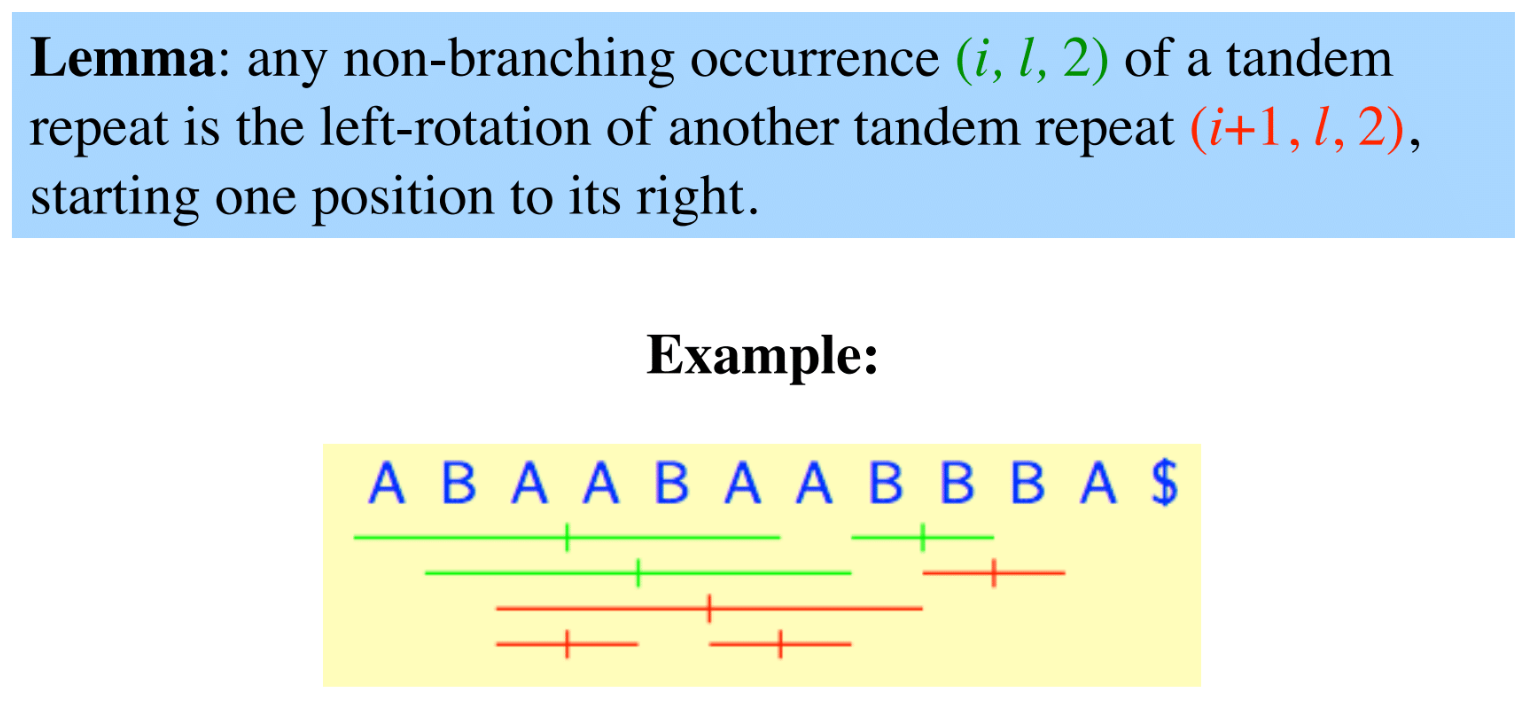

#### For suffix trees

When we use this concept in suffix trees, we gather a leaf list for each internal node. If the current suffix index i and the the previous one i-1 is in the same nodes leaflist, then these are branching tandem repeat. This is only true additionally if the node depth is not greater than the length of the pattern l.

For the basic algorithm we would do the following:

1.select an unmarked internal node v.
mark v and execute step 2a and 2b for it

2a.collect the leaflist LL(v)

2b.for each leaf i in LL(v) test wether the leaf j = i + D(v) is in LL(v).
if so, test wether S[i] != S[i + 2D(v)]. There is a branching tandem repeat og length 2D(v) startin at position i if and only if both tests return true.  

Step 1 is repeated until all nodes are marked

The algorithm outlined would do the job, but the internal testing makes it run in O(n^2).
Instead we can make the testing run in constant time by add a depth firs numbering to the leaves, and from this make a look-up table

The way this works is by checking the current nodes leaf list, and comparing it to the childrens leaflist to see if 2 given substrings split up.

In [12]:
# depth first numbering was constructed under the suffix tree class

string = "ABAABAABBBA"
suffix_tree = SuffixTree(string)

s_list, df_list = suffix_tree.df_numbering()
print(f"suffix_list: {s_list} \ndf_list:     {df_list}")

suffix_list: [0, 3, 6, 2, 5, 10, 1, 4, 9, 7, 8, 11] 
df_list:     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Visualization saved as Suffix_tree_compressed.png


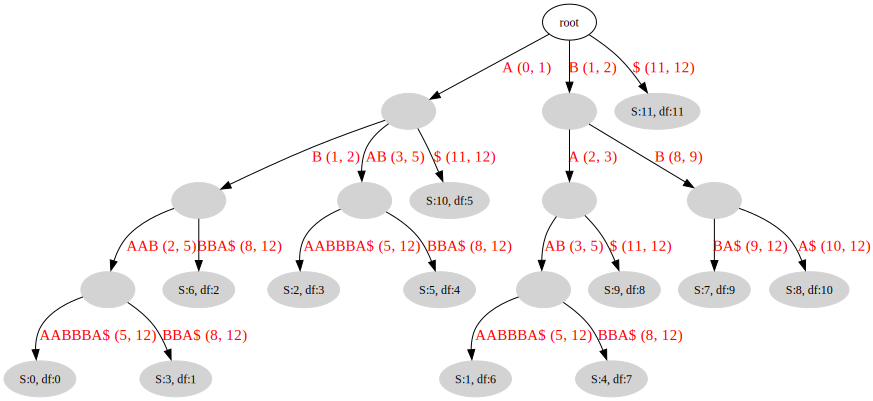

In [13]:
# added an if statement to visualization
# checks if df_numbering has been done
# and then adds both numbers in the leaf label if so

suffix_tree.visualize() 

#### basic search algorithm - searching for repeats in suffix trees

Thought process of the basic version

each node should be marked when visited 
where the following steps are repeat until all nodes are marked
Everything begins unmarked

step 1: select unmarked node v. Mark it and proceed to step 2a and b

step 2a: collect node v's leaflist 

step 2b: each leafi in leaflist, test the following
- is leaf j = i + D(v) is in leaflist for v
- if so, test if S[i] != S[i + 2D(v)] <- Checks if i and j are not in any same leaflist at D(v)
- there is a branching repeat of length 2D(v) at position i if both tests are true

would use O(leaflist(v)) for every node. The speedup versions avoids this.

In [14]:
# helper function
def translate_leaf(x, s_list, df_list, s_to_df = True):
    """ 
    Translates x from number in s_list into df_list, if s_to_df == True
    If s_to_df not True, then we translate from df_list to s_list idx
    """
    if s_to_df == True:
        idx = s_list.index(x)
        return df_list[idx]
    else: 
        idx = df_list.index(x)
        return s_list[idx]

def repeat_search(self):
    """
    moves through all internal nodes and marks them, depth-first. 
    For each internal node, every leaf in leaf_range is check if the current depth/length of node v
    also has leaf j=i+depth(v) in the leaf_range. if so check if idx right after 2*depth(v)
    matches i. If not we have a BTR.
    Returns a list of (i_suf, depth) which starts a BTR

    Doctest examples:
        >>> repeat_search(SuffixTree("abaabaabbba"))
        [(2, 1), (5, 1), (2, 3), (8, 1)]
    """
    S = self.string
    s_list, df_list = self.df_numbering()

    BTR_list = []

    def dfs(node, current_path):
        if not node.children: #base: no children so leaf
            return 

        #recursively visit all nodes
        for child in node.children.values():
            edge_label = self.string[child.start:child.end] # gather the edge label, so we keep track of current path/depth
            dfs(child, current_path + edge_label)

        # 2a - get leaflist (from the node numbering function)
        leaf_list = (node.leaf_range)
        depth = len(current_path) # uses current path to find depth of current node
        
        # 2b - checks for i
        for i in range(leaf_list[0], leaf_list[1]+1):
            i_suf = translate_leaf(i, s_list, df_list, s_to_df = False)
            j_suf = i_suf + depth
            j = translate_leaf(j_suf, s_list, df_list, s_to_df=True)
            
            if j >= leaf_list[0] and j <= leaf_list[1]:
                if S[i_suf] != S[i_suf + 2*depth]:
                    #print(f"{(i_suf, depth)}, i_suf: {S[i_suf]}, i+2d: {S[i_suf + 2*depth]}\nFull BTR: {S[i_suf:i_suf+2*depth]}\n") # report BTR   
                    BTR_list.append((i_suf, depth))

        
    dfs(self.root, "") # initialize recursion
    return BTR_list


In [15]:
print(repeat_search(suffix_tree))

# True branching repeats for ABAABAABBBA
# AABAAB,   i_suf: 2    length: 3
# AA,       i_suf: 2    length: 1
# AA,       i_suf: 5    length: 1
# BB,       i_suf: 8    length: 1

[(2, 3), (2, 1), (5, 1), (8, 1)]


#### Speedup version

We dont have the time to spend iterating over every possiblity within the leaflist, and in that spend O(|LL(v)|) per node. Instead first determine the biggest subtree for a node (biggest child leaflist) and then we only check for i in every other child than the large one. 

This enables us to look at less possible i's and the trick here is that


 - step 1: select unmarked node v. Mark it and proceed to step 2a, b and c
    - This step is solve by doing depth first, where we only visit each node once

 - step 2a: collect node v leaflist  
    - and find childrens leaflist size to determine Large(v) = LL(v') and small(v) = LL'(v)

 - step 2b: each leaf i in leaflist, test the following:
    - is leaf j = i + D(v) is in leaflist for v
    - if so, test if S[i] != S[i + 2D(v)] <- Checks if i and j are not in any same leaflist at D(v)
    - there is a branching repeat of length 2D(v) at position i if both tests are true

- step 2c: Do same tests each leaf j in leaflist for v, where i = j-D(v)

In [16]:
def sub_range(total_range, largest_range):
    """
    function to subtract the largest range of a child node 
    from the total leaf range of the current node
    Returns 2 tuples if the largest group is bordering the dge of the total interval
    1 of them is (None, None)
    """
    total_start, total_end = total_range
    largest_start, largest_end = largest_range

    ### Observation: 3 cases for the largest groups placement in the interval:
    # largest start at total start
    if total_start == largest_start:
        small_start, small_end = largest_end+1, total_end
        return (None), (small_start, small_end)

    # largest end at total end
    elif total_end == largest_end:
        small_start, small_end = total_start, largest_start-1
        return (small_start, small_end), (None)

    # largest inbetween total start and end - seperates the small_v into 2 intervals
    else:
        remaining_range_1 = (total_start, largest_start-1) 
        remaining_range_2 = (largest_end+1, total_end)
        return remaining_range_1, remaining_range_2


def checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v,s_list, df_list):
    """
    Do the checks from 2b and 2c for i and j in the leaflists  
    """
    # 2b - checks for i
    for i in range(small_v[0], small_v[1]+1):
        i_suf = translate_leaf(i, s_list, df_list, s_to_df = False)
        j_suf = i_suf + depth
        j = translate_leaf(j_suf, s_list, df_list, s_to_df = True)

        if j >= leaf_list[0] and j <= leaf_list[1]:
            if S[i_suf] != S[i_suf + 2*depth]:
                BTR_list.append((i_suf, depth))
    
    # 2c - checks for j
        j_suf = i_suf - depth
        if j_suf not in s_list:
            continue
        j = translate_leaf(j_suf, s_list, df_list, s_to_df = True)
        if j >= large_v[0] and j <= large_v[1]:
            BTR_list.append((j_suf, depth))



def repeat_search_speedup(self):
    """
    Faster version of repeat_search. Finds the largest leaflist of children, and avoids using
    i as leaves in this Large(v). additionally does checks for j and not just i.
    Returns a list of (i_suf, depth) which starts a BTR

    Doctest examples:
        >>> repeat_searcg(SuffixTree("abaabaabbba"))
        [(2, 1), (5, 1), (2, 3), (8, 1)]
    """
    S = self.string
    s_list, df_list = self.df_numbering()
    BTR_list = []

    def dfs(node, current_path):
        if not node.children: #base: no children so leaf
            return
        
        largest_child = (None, 0) # (node_id, size) , keeps track of largest child
        
        #recursively visit all nodes
        for child in node.children.values():
            edge_label = self.string[child.start:child.end]             # gather the edge label, so we keep track of current path/depth
            dfs(child, current_path + edge_label)
            
            child_size = child.leaf_range[1]-child.leaf_range[0] + 1    # +1 since we want all leaves inside the node and not just difference
            if child_size > largest_child[1]:
                largest_child = (child, child_size)
        
        # 2a - get leaflist (from the node numbering function)
        leaf_list = (node.leaf_range)
        depth = len(current_path) # uses current path to find depth of current node

        if depth != 0:
            #determine small(v) and large(v)
            large_v = largest_child[0].leaf_range # define large(v)
            small_v = sub_range(leaf_list, large_v) # define small(v)

            if small_v[0] == None:      # large is in first part of total range
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[1], s_list, df_list)
            elif small_v[1] == None:    # large is in later part of total range
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[0], s_list, df_list)
            else:                       # large is in the middel of total range
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[0], s_list, df_list)
                checks_in_leaflists(BTR_list, S, depth, leaf_list, large_v, small_v[1], s_list, df_list)

    dfs(self.root, "") # initialize recursion
    return BTR_list

suffix_tree = SuffixTree("ABAABAABBBA")
suffix_tree.df_numbering()

print(repeat_search_speedup(suffix_tree))

[(2, 3), (2, 1), (5, 1), (8, 1)]


Visualization saved as Suffix_tree_compressed.png


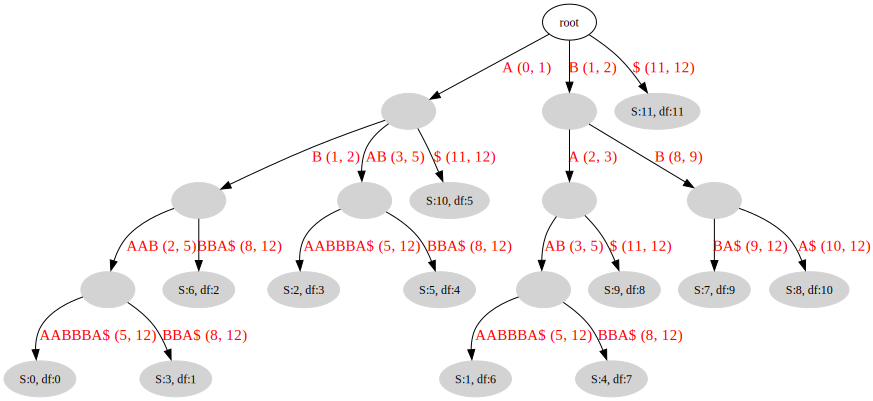

In [17]:
suffix_tree = SuffixTree("ABAABAABBBA")
suffix_tree.df_numbering()
suffix_tree.visualize()

#### validating the repeat search function
Lets try and generate some strings and their BTRs without using a suffixtree and worrying about the time consumption to validate if our function is giving the correct results.

In [18]:
import random

def find_btr(seq):
    """
    finds all BTRs within a given string
    """
    seq = seq + "$"
    btrs = []
    n = len(seq)
    for length in range(1, n // 2 + 1):  # search all possible lengths
        for i in range(n - 2 * length + 1):  # every possible repeat pair
            repeat1 = seq[i:i+length]
            repeat2 = seq[i+length:i+2*length]
            if repeat1 == repeat2:
                if i+2*length < n and seq[i+1:i+length+1] != seq[i+length+1:i+2*length+1]: # check shift to the right is no longer a repeat
                    btrs.append((i, length))
    return btrs

find_btr("ABAABAABBBA")

[(2, 1), (5, 1), (8, 1), (2, 3)]

In [19]:
# the generate random input string from earlier
num_of_strings = 3
len_of_strings = random.randint(30,100)
alphabet = "atc"

random_strings = [random_input_string(len_of_strings, alphabet) for _ in range(num_of_strings)]

# BTRs for each string
btrs_per_string = [find_btr(s) for s in random_strings]

# BTRs using the suffix tree
btrs_per_suffixtree = []
for s in random_strings:
    suffix_tree = SuffixTree(s)
    suffix_tree.df_numbering()
    search_result = repeat_search_speedup(suffix_tree)
    btrs_per_suffixtree.append(search_result)

for i, s in enumerate(random_strings):
    print(f"String {i+1}: {s}")
    print(f"BTR string function:     {sorted(btrs_per_string[i])}")
    print(f"BTR suffixtree function: {sorted(btrs_per_suffixtree[i])}")
    print(f"Functions return same: {sorted(btrs_per_string[i]) == sorted(btrs_per_suffixtree[i])}\n")
    if sorted(btrs_per_string[i]) != sorted(btrs_per_suffixtree[i]): # Not same we stop and report it
        print(f"FAILED with string {i+1}: {s}")
        break

String 1: aaccaacatccccccaaaattccacattcaattaacttttatttaaaacacctatacatataacaataaatcccaaaccc
BTR string function:     [(0, 1), (2, 1), (4, 1), (9, 3), (11, 2), (13, 1), (15, 2), (17, 1), (19, 1), (21, 1), (22, 2), (26, 1), (29, 1), (31, 1), (33, 1), (36, 2), (37, 4), (38, 1), (42, 1), (44, 2), (46, 1), (47, 2), (50, 1), (52, 2), (58, 2), (61, 1), (64, 1), (68, 1), (72, 1), (75, 1), (78, 1)]
BTR suffixtree function: [(0, 1), (2, 1), (4, 1), (9, 3), (11, 2), (13, 1), (15, 2), (17, 1), (19, 1), (21, 1), (22, 2), (26, 1), (29, 1), (31, 1), (33, 1), (36, 2), (37, 4), (38, 1), (42, 1), (44, 2), (46, 1), (47, 2), (50, 1), (52, 2), (58, 2), (61, 1), (64, 1), (68, 1), (72, 1), (75, 1), (78, 1)]
Functions return same: True

String 2: taccatattcccctcatacttaaaattctcctccatacacattaccacaacaacaccattcaatacacaccacactctta
BTR string function:     [(2, 1), (4, 2), (7, 1), (9, 2), (11, 1), (19, 1), (21, 2), (23, 1), (25, 1), (26, 2), (28, 3), (29, 1), (32, 1), (37, 2), (41, 1), (44, 1), (45, 2), (48, 1), (49

Since we found all the branching tnadem repeats, we can now by check the index next to them get all the tandem repeats.

In [20]:
def left_turn(S, BTR_list):
    S = S + '$'
    repeats = []

    for i in BTR_list:        
        length = i[1]
        x = i[0]            # start idx
        y = i[0]+length     # start of 2nd part of repeat
        while S[x] == S[y] and x >= 0:
            repeats.append((x, length))
            x = x-1
            y = y-1
    return repeats

text = "aaaaaaaaaaa"
tmp_tree = SuffixTree(text)
tmp_tree.df_numbering()
tmp_BTR = repeat_search(tmp_tree)

all_repeats = left_turn(text, tmp_BTR)
all_repeats

[(1, 5),
 (0, 5),
 (3, 4),
 (2, 4),
 (1, 4),
 (0, 4),
 (5, 3),
 (4, 3),
 (3, 3),
 (2, 3),
 (1, 3),
 (0, 3),
 (7, 2),
 (6, 2),
 (5, 2),
 (4, 2),
 (3, 2),
 (2, 2),
 (1, 2),
 (0, 2),
 (9, 1),
 (8, 1),
 (7, 1),
 (6, 1),
 (5, 1),
 (4, 1),
 (3, 1),
 (2, 1),
 (1, 1),
 (0, 1)]

Finally lets make a function that translates these indices and lengths into the actual repeating strings.

In [21]:
def show_repeats(S, repeats):
    S = S + '$'
    print(f"The string: {S}")
    for i in range(len(repeats)):
        start_idx = repeats[i][0]
        length = repeats[i][1]
        print(f"Repeat number {i}: {S[start_idx:start_idx+length]}")

show_repeats(text, all_repeats)

The string: aaaaaaaaaaa$
Repeat number 0: aaaaa
Repeat number 1: aaaaa
Repeat number 2: aaaa
Repeat number 3: aaaa
Repeat number 4: aaaa
Repeat number 5: aaaa
Repeat number 6: aaa
Repeat number 7: aaa
Repeat number 8: aaa
Repeat number 9: aaa
Repeat number 10: aaa
Repeat number 11: aaa
Repeat number 12: aa
Repeat number 13: aa
Repeat number 14: aa
Repeat number 15: aa
Repeat number 16: aa
Repeat number 17: aa
Repeat number 18: aa
Repeat number 19: aa
Repeat number 20: a
Repeat number 21: a
Repeat number 22: a
Repeat number 23: a
Repeat number 24: a
Repeat number 25: a
Repeat number 26: a
Repeat number 27: a
Repeat number 28: a
Repeat number 29: a


### Testing 
Reminder of the theoretical runtime goals:
- Normal suffix tree construction = O(n^2)
- McCrieght suffix tree construction = O(n)
- Stoye n' Gusfield repeat search = O(n*log(n)) #???
 

In [22]:
import time 

def measure_time(func, *args, **kwargs):
    """
    Measure the time it takes to run a function
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, result


#### Test case 1: Random string
General test case where we generate random strings with the same symbols as found in DNA

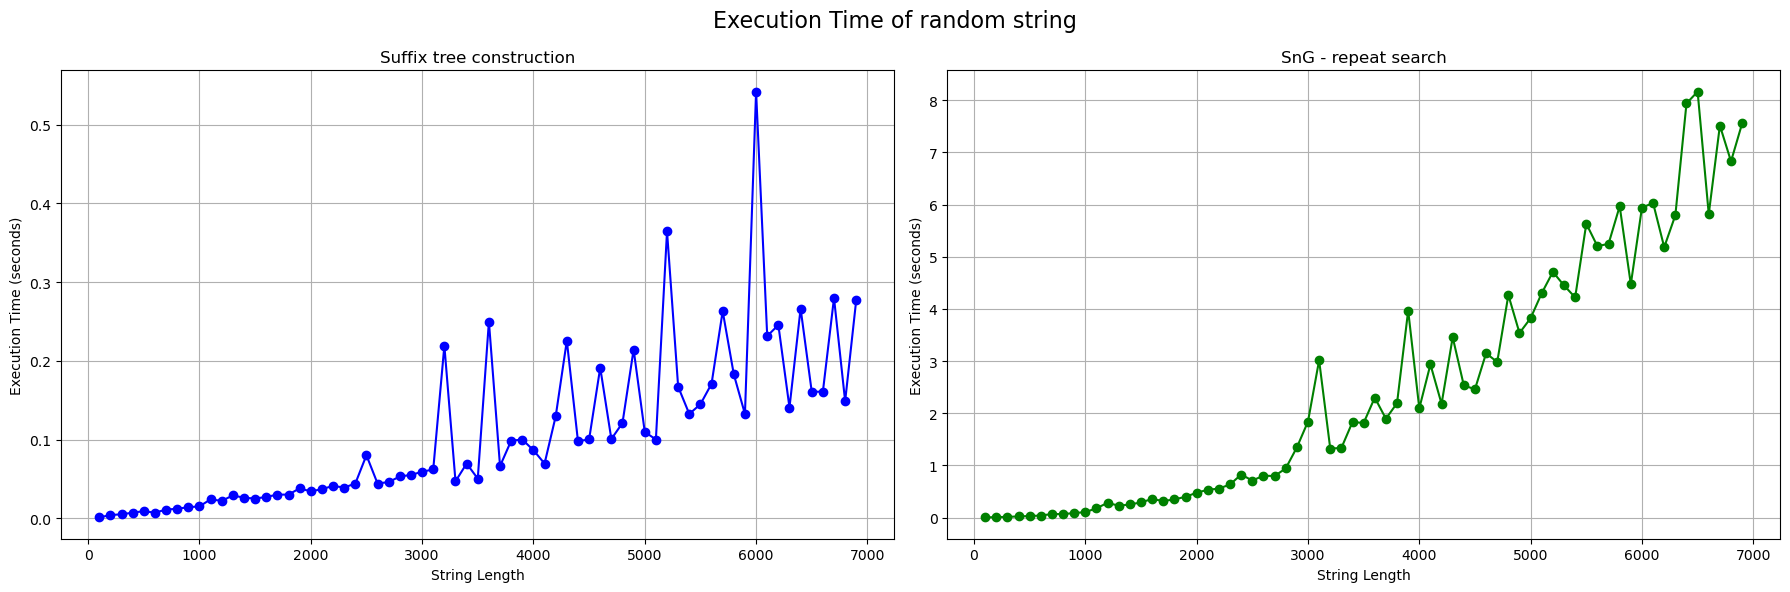

In [47]:
import matplotlib.pyplot as plt

#Size of input strings
string_lengths = range(100, 7000, 100)  


runtimes_func1 = []
runtimes_func2 = []

for length in string_lengths:
    test_string = random_input_string(length, symbols='atgc')
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1.append(runtime_1)
    suffix_tree.df_numbering()
    #measure for repeat_search
    runtime_2, btr_repeats = measure_time(repeat_search_speedup, suffix_tree)
    runtimes_func2.append(runtime_2)

#create subplots: 
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Execution Time of random string', fontsize=16)


# plot1
axes[0].plot(string_lengths, runtimes_func1, marker='o', color='blue')
axes[0].set_title('Suffix tree construction')
axes[0].set_xlabel('String Length')
axes[0].set_ylabel('Execution Time (seconds)')
axes[0].grid(True)

# plot2
axes[1].plot(string_lengths, runtimes_func2, marker='o', color='green')
axes[1].set_title('SnG - repeat search')
axes[1].set_xlabel('String Length')
axes[1].set_ylabel('Execution Time (seconds)')
axes[1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [24]:
# free mem
del runtimes_func1, runtimes_func2, runtime_1, runtime_2, suffix_tree, btr_repeats

#### Test case 2: Same string
The string of only 1 repeating symbol is a unique case that generates the most unbalanced suffix possible. 

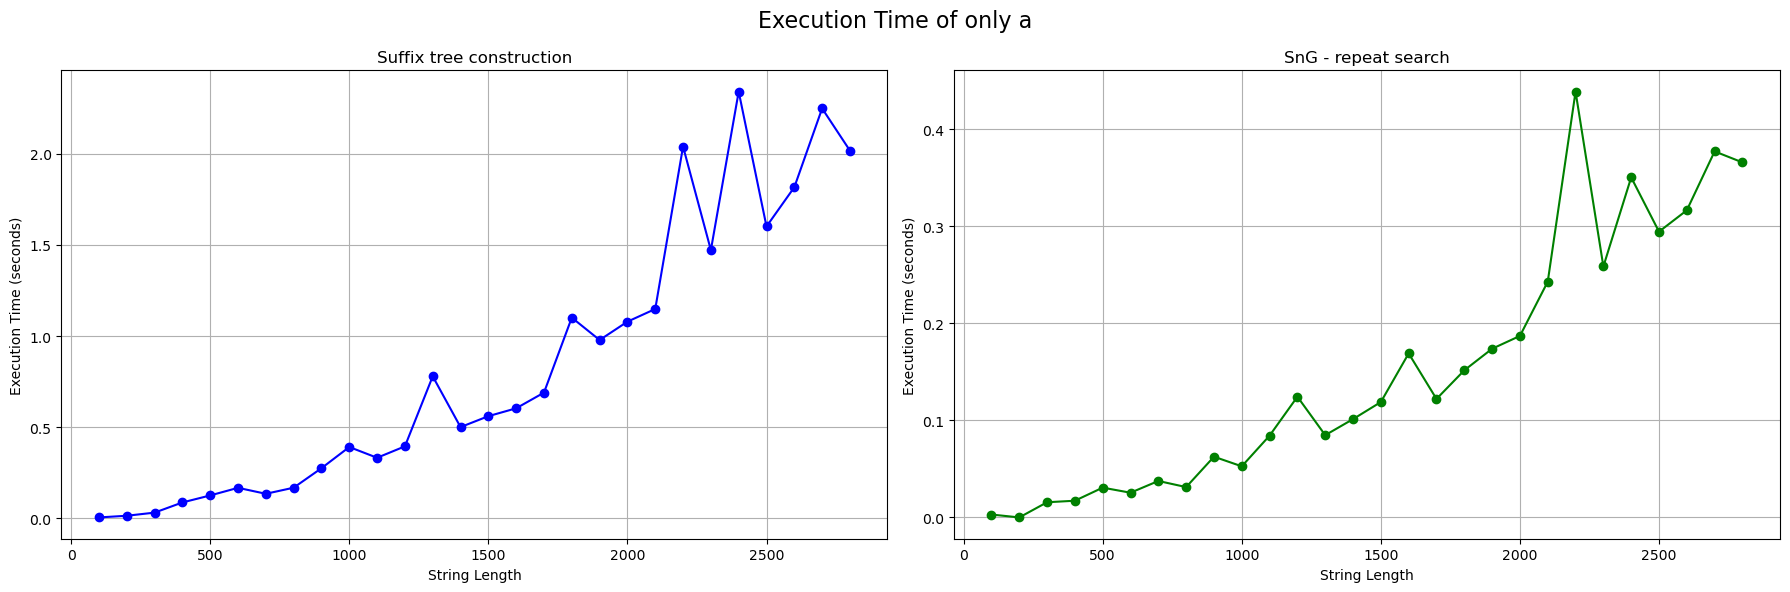

In [25]:
#Size of input strings
string_lengths = range(100, 2900, 100)  

runtimes_func1 = []
runtimes_func2 = []

for length in string_lengths:
    test_string = 'a' * length  #generate only a string
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1.append(runtime_1)
    suffix_tree.df_numbering()
    #measure for repeat_search
    runtime_2, btr_repeats = measure_time(repeat_search_speedup, suffix_tree)
    runtimes_func2.append(runtime_2)

#create subplots:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Execution Time of only a string', fontsize=16)

# plot1
axes[0].plot(string_lengths, runtimes_func1, marker='o', color='blue')
axes[0].set_title('Suffix tree construction')
axes[0].set_xlabel('String Length')
axes[0].set_ylabel('Execution Time (seconds)')
axes[0].grid(True)

# plot2
axes[1].plot(string_lengths, runtimes_func2, marker='o', color='green')
axes[1].set_title('SnG - repeat search')
axes[1].set_xlabel('String Length')
axes[1].set_ylabel('Execution Time (seconds)')
axes[1].grid(True)

#adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [27]:
# Free up memory
del runtimes_func1, runtimes_func2, runtime_1, runtime_2, suffix_tree, btr_repeats

#### Test case 3: Fibonacci string
The fibonacci string is another example of an extending string that generates alot of tandem repeats.

In [42]:
def fibonacci_string(n):
    """
    fibonacci string generator, with (a,b) as alhpabet
    """
    if n == 1:
        return 'a'
    elif n == 2:
        return 'b'
    
    Fa = 'a'
    Fb = 'b'
    for i in range(2, n+1):
        Fn = Fa + Fb
        Fa = Fb 
        Fb = Fn
    return Fb

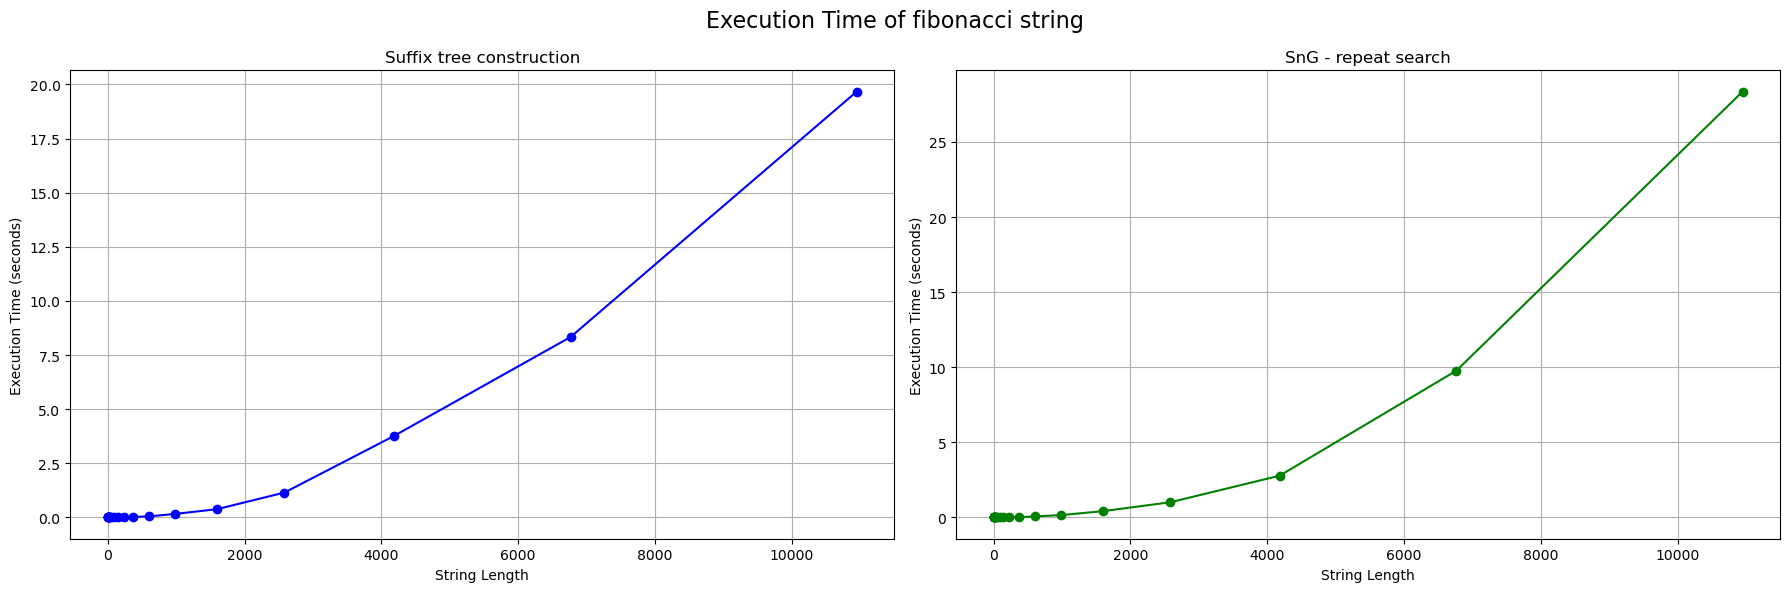

In [48]:

#Size of input strings
fib_numbers= range(1, 21)  

fib_lengths = []
runtimes_func1 = []
runtimes_func2 = []


for n in fib_numbers:
    test_string = fibonacci_string(n)
    fib_lengths.append(len(test_string))

    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1.append(runtime_1)
    suffix_tree.df_numbering()
    #measure for repeat_search
    runtime_2, btr_repeats = measure_time(repeat_search_speedup, suffix_tree)
    runtimes_func2.append(runtime_2)

#create subplots:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Execution Time of fibonacci string', fontsize=16)

# plot1
axes[0].plot(fib_lengths, runtimes_func1, marker='o', color='blue')
axes[0].set_title('Suffix tree construction')
axes[0].set_xlabel('String Length')
axes[0].set_ylabel('Execution Time (seconds)')
axes[0].grid(True)

# plot2
axes[1].plot(fib_lengths, runtimes_func2, marker='o', color='green')
axes[1].set_title('SnG - repeat search')
axes[1].set_xlabel('String Length')
axes[1].set_ylabel('Execution Time (seconds)')
axes[1].grid(True)

#adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [ ]:
# free up mem
del runtimes_func1, runtimes_func2, runtime_1, runtime_2, suffix_tree, btr_repeats

# next on the agenda
tests the run time for the algorithms. Do they fit the theoretical runtimes?

potentially make the fibonacci string as a testing example

Start implementing Mccreights algorithm


Note:
For only a string: At string length 3000 the SuffixTree hits a recursion depth limit
